# Categorical DQN (C51)

## Introduction

Categorical DQN (C51) is a distributional reinforcement learning algorithm that models the entire distribution of returns instead of just their expected value. It was introduced by Bellemare et al. in 2017 and represents a significant advancement in understanding value distributions in RL.

## Core Concepts

### Distributional Perspective

Instead of learning the expected Q-value, C51 learns the distribution of possible returns:

$$
Z(s,a) \sim R(s,a) + \gamma Z(s',a')
$$

where $Z$ represents the random return and $\sim$ denotes distributional equality.

### Value Distribution Parameterization

1. **Support Set**
   - Fixed set of atoms: $\{z_1, z_2, ..., z_N\}$
   - Typically N=51 atoms (hence "C51")
   - Range $[V_{min}, V_{max}]$ divided into $N-1$ equal intervals

2. **Probability Mass**
   - Network outputs probabilities p_i for each atom
   - $Z(s,a) = \sum_i p_i(s,a) * \delta_{z_i}$
   where $\delta_{z_i}$ is the Dirac delta at atom $z_i$

### Distributional Bellman Update

1. **Project Bellman Update**
   - For each atom $z_j$:
     $T_{\gamma}z_j = r + \gamma z_j$
   - Project onto original support using categorical projection $\Phi$

2. **KL Divergence Loss**
   - Minimize KL divergence between predicted and target distributions:
     $L(\theta) = D_{KL}(\Phi T Z_{\theta'} || Z_{\theta})$

## Training Process

1. **Forward Pass**
   - Input state s to network
   - Output probability distribution over atoms for each action

2. **Action Selection**
   - Use expected value: $\mathbb{E}[Z(s,a)] = \sum_i p_i(s,a) * z_i$
   - Follow $\epsilon$-greedy policy based on expected values

3. **Learning**
   - Sample transitions from replay buffer
   - Compute target distribution using Bellman update
   - Project onto support
   - Update network to minimize KL divergence

## Advantages

1. **Rich Value Information**
   - Captures multimodality in returns
   - Better handles stochastic environments
   - Provides uncertainty information

2. **Improved Performance**
   - More stable learning
   - Better final policies
   - State-of-the-art results on many tasks

3. **Risk-Aware Decision Making**
   - Can use full distribution for decision making
   - Enables risk-sensitive policies

## Limitations

1. **Fixed Support**
   - Must choose V_min and V_max beforehand
   - May not capture outlier returns

2. **Computational Overhead**
   - More parameters than standard DQN
   - Projection operation adds complexity

3. **Hyperparameter Sensitivity**
   - Number of atoms
   - Support range
   - Learning rate

## References

1. Bellemare, M. G., Dabney, W., & Munos, R. (2017). "A distributional perspective on reinforcement learning." International Conference on Machine Learning.

2. Dabney, W., Rowland, M., Bellemare, M. G., & Munos, R. (2018). "Distributional reinforcement learning with quantile regression." AAAI Conference on Artificial Intelligence.

3. Bellemare, M. G., Dabney, W., & Munos, R. (2022). "Distributional Reinforcement Learning." MIT Press.


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from typing import Dict
import gymnasium as gym
from collections import deque
from typing import Tuple
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer:
    """Experience replay buffer for RL agents."""

    def __init__(self, maxlen: int = 100_000):
        """Initialize replay buffer.

        Args:
            maxlen (int): Maximum size of the buffer
        """
        self.buffer = deque(maxlen=maxlen)

    def append(
        self, experience: Tuple[np.ndarray, np.ndarray, np.ndarray, float, bool]
    ) -> None:
        """Add experience to buffer.

        Args:
            experience (tuple): (state, next_state, action, reward, done)
        """
        self.buffer.append(experience)

    def sample(
        self,
        batch_size: int,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
    ) -> Dict[str, torch.Tensor]:
        """Sample a batch of experiences.

        Args:
            batch_size (int): Size of batch to sample
            device (torch.device): Device to put tensors on

        Returns:
            dict: Dictionary containing batched experiences
        """
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, next_states, actions, rewards, dones = zip(
            *[self.buffer[idx] for idx in indices]
        )

        # Convert to torch tensors
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        # One-hot encode actions
        actions_one_hot = torch.zeros(
            batch_size, actions.max().item() + 1, device=device
        )
        actions_one_hot.scatter_(1, actions.unsqueeze(1), 1)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)

        return {
            "states": states,
            "next_states": next_states,
            "actions": actions_one_hot,
            "rewards": rewards,
            "dones": dones,
        }

    def __len__(self) -> int:
        return len(self.buffer)


In [3]:
C51_CONFIG = {
    "hidden_dim": 256,
    "n_atoms": 51,  # Number of atoms
    "v_min": -10.0,  # Minimum value of the support
    "v_max": 10.0,  # Maximum value of the support
}


class C51Net(nn.Module):
    """Categorical DQN (C51) network."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        n_atoms: int = C51_CONFIG["n_atoms"],
        v_min: float = C51_CONFIG["v_min"],
        v_max: float = C51_CONFIG["v_max"],
        hidden_dim: int = C51_CONFIG["hidden_dim"],
    ):
        super().__init__()
        self.action_dim = action_dim
        self.n_atoms = n_atoms
        self.register_buffer("supports", torch.linspace(v_min, v_max, n_atoms))
        self.delta_z = (v_max - v_min) / (n_atoms - 1)

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim * n_atoms),
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        batch_size = state.shape[0]
        logits = self.net(state).view(batch_size, self.action_dim, self.n_atoms)
        probs = F.softmax(logits, dim=-1)
        return probs

    @torch.no_grad()
    def get_action(self, state: np.ndarray) -> int:
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        probs = self.forward(state)
        q_values = (probs * self.supports).mean(dim=-1)
        return q_values.argmax().item()


In [4]:
class C51Agent:
    """Categorical DQN (C51) Agent."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        learning_rate: float = 3e-4,
        gamma: float = 0.99,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
        n_atoms: int = C51_CONFIG["n_atoms"],
        v_min: float = C51_CONFIG["v_min"],
        v_max: float = C51_CONFIG["v_max"],
        hidden_dim: int = C51_CONFIG["hidden_dim"],
    ):
        super().__init__()
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_atoms = n_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (n_atoms - 1)

        # Create networks
        self.online_net = C51Net(
            state_dim, action_dim, n_atoms, v_min, v_max, hidden_dim
        ).to(self.device)
        self.target_net = C51Net(
            state_dim, action_dim, n_atoms, v_min, v_max, hidden_dim
        ).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())

        self.optimizer = optim.Adam(self.online_net.parameters(), lr=learning_rate)

    def choose_action(self, state: np.ndarray, epsilon: float = 0.0) -> int:
        if np.random.random() < epsilon:
            return np.random.randint(self.action_dim)
        return self.online_net.get_action(state)

    def _project_distribution(
        self, next_distr: torch.Tensor, rewards: torch.Tensor, dones: torch.Tensor
    ) -> torch.Tensor:
        """Project the distribution for C51."""
        batch_size = len(rewards)

        # Project using the Bellman update
        proj_distr = torch.zeros((batch_size, self.n_atoms), device=self.device)
        delta_z = self.delta_z
        v_min, v_max = self.v_min, self.v_max

        # Compute projection
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        support = self.online_net.supports

        target_z = rewards + (1 - dones) * self.gamma * support
        target_z = target_z.clamp(v_min, v_max)

        b = (target_z - v_min) / delta_z
        low = b.floor().long()
        high = b.ceil().long()

        # Handle corner cases
        low[(high > 0) * (low == high)] -= 1
        high[(low < (self.n_atoms - 1)) * (low == high)] += 1

        # Distribute probability
        offset = (
            torch.linspace(
                0, ((batch_size - 1) * self.n_atoms), batch_size, device=self.device
            )
            .long()
            .unsqueeze(1)
            .expand(batch_size, self.n_atoms)
        )

        proj_distr.view(-1).index_add_(
            0, (low + offset).view(-1), (next_distr * (high.float() - b)).view(-1)
        )
        proj_distr.view(-1).index_add_(
            0, (high + offset).view(-1), (next_distr * (b - low.float())).view(-1)
        )

        return proj_distr

    def train(self, batch: Dict[str, torch.Tensor]) -> float:
        states = batch["states"]
        next_states = batch["next_states"]
        actions = batch["actions"]
        rewards = batch["rewards"]
        dones = batch["dones"]

        # Get current distribution
        current_distr = self.online_net(states)
        action_indices = actions.argmax(dim=1)
        current_distr = current_distr[torch.arange(len(states)), action_indices]

        # Get target distribution
        with torch.no_grad():
            next_distr = self.target_net(next_states)
            next_actions = (next_distr * self.online_net.supports).sum(2).argmax(1)
            next_distr = next_distr[torch.arange(len(states)), next_actions]

            # Project next distribution
            target_distr = self._project_distribution(next_distr, rewards, dones)

        # Calculate cross-entropy loss
        loss = -(target_distr * torch.log(current_distr + 1e-8)).sum(1).mean()

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target(self) -> None:
        self.target_net.load_state_dict(self.online_net.state_dict())


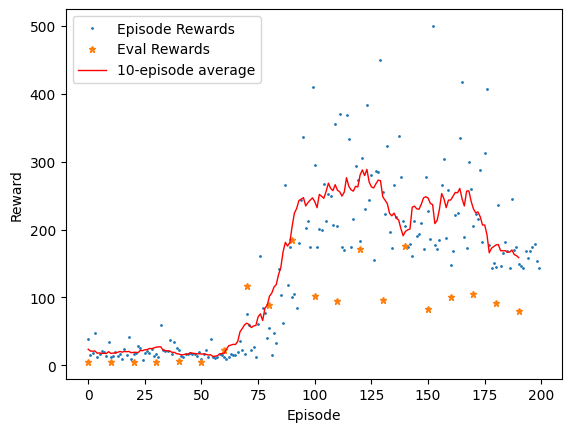

In [9]:
def train_c51(env_name: str, device: str = "cuda") -> None:
    # Create environment
    env = gym.make(env_name)

    # Get state and action dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize agent
    agent = C51Agent(state_dim, action_dim, device=device)

    # Initialize replay buffer
    memory = ReplayBuffer(maxlen=100_000)

    # Training loop
    total_steps = 0
    episode_rewards = []
    eval_rewards = []
    eval_episodes = []

    # Training parameters
    episodes = 200
    eval_freq = 10
    n_eval_episodes = 4
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 5000
    min_memory_size = 1000
    target_update_freq = 100
    batch_size = 128

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Calculate epsilon for exploration
            epsilon = max(
                epsilon_end,
                epsilon_start
                - (epsilon_start - epsilon_end) * total_steps / epsilon_decay,
            )

            # Select action
            action = agent.choose_action(state, epsilon)

            # Take step in environment
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            episode_reward += reward
            total_steps += 1
            # Store experience in replay buffer
            memory.append(
                (
                    state,
                    next_state,
                    int(action),
                    reward,
                    done,
                )
            )

            # Update state
            state = next_state

            loss = 0.0

            # Train agent
            if len(memory) >= min_memory_size:
                batch = memory.sample(batch_size)
                loss = agent.train(batch)

                # Update target network
                if total_steps % target_update_freq == 0:
                    agent.update_target()

            if episode % 10 == 0:
                print(
                    f"Episode {episode:>{len(str(episodes))}}/{episodes} | "
                    f"Reward: {episode_reward:.2f} | "
                    f"Loss: {loss:.4f}",
                    end="\r",
                )

        # Track episode rewards
        episode_rewards.append(episode_reward)

        # Evaluate agent
        if episode % eval_freq == 0:
            eval_reward_list = []
            for _ in range(n_eval_episodes):
                state, _ = env.reset()
                eval_reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        action = agent.choose_action(state, epsilon=0.0)
                    state, reward, done, truncated, _ = env.step(action)
                    eval_reward += reward
                    done = done or truncated
                    eval_reward_list.append(eval_reward)

            mean_eval_reward = np.mean(eval_reward_list)
            eval_rewards.append(mean_eval_reward)
            eval_episodes.append(episode)

    # Close environment
    env.close()

    plt.plot(episode_rewards, "o", ms=1, label="Episode Rewards")
    plt.plot(
        np.arange(len(eval_rewards)) * eval_freq,
        eval_rewards,
        "*",
        ms=5,
        label="Eval Rewards",
    )
    plt.plot(
        np.convolve(episode_rewards, np.ones((10,)) / 10, mode="valid"),
        "r-",
        lw=1,
        label="10-episode average",
    )
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()


train_c51("CartPole-v1")
